<a href="https://colab.research.google.com/github/Kidinnu/classes_programming/blob/master/reentry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Движение спускаемого аппарата в  атмосфере 

Простейшая плоская модель движения СА в атмосфере

_Nguyen X. Vinh, Adolf Busemann, Robert D. Culp_ Hypersonic and planetary entry flight mechanics

The Unevrsity of Michigan Press

In [0]:
from collections import namedtuple
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.pylab as pylab
params = {'legend.fontsize': 14, 'figure.figsize': (10, 7), 'axes.labelsize': 14,
         'axes.titlesize':14, 'xtick.labelsize':14,'ytick.labelsize':14}
pylab.rcParams.update(params)

In [0]:
# Модель атмосферы в диапазоне от 0 до 100 км с погрешностью 1,5% 
# В. А. ЯРОШЕВСКИЙ "АППРОКСИМАЦИЯ МОДЕЛИ СТАНДАРТНОЙ АТМОСФЕРЫ" 
# Ученые записки ЦАГИ, т. XL, №3, 2009.
a  = np.array([-6.3759,-7.3012,-1.1817])
b  = np.array([-0.4754,-0.0096,-0.0068,-0.0120,0.0042]);
c  = np.array([ 0.1803, 0.0872,-0.0153, 0.0145,0     ]);

def rho(h):
  # Функция вычисления плотности воздуха 
  # высота h задаётся в километрах
  # результат -- плотность кг/м3
  x = h/50.0-1
  sa = a[0] + a[1]*x + a[2]*x*x
  sbc= np.sum( (b[i]*np.cos((i+1)*np.pi*x) + c[i]*np.sin((i+1)*np.pi*x) for i in range(5)) ) 
  return np.exp(sa + sbc)

# Гравитационный параметр Земли
mu = 398600.4415e9
# Радиус Земли
Re = 6371000.0

def g_acc(h):
  # Вычисление ускорения свободного падения м/с^2 на высоте h (в метрах) 
  return mu/(Re+h)**2

## Уравнения движения

$$
\frac{dV}{dt} = - \frac{C_d S_m q}{m} - g \sin \theta,\quad V \frac{d \theta}{dt} = \frac{C_l S_m q}{m} - \left(g-\frac{V^2}{r}\right) \cos \theta, \quad \frac{dr}{dt} = V \sin \theta
$$
где $V$ - скорость СА;

$\vartheta$ -- угол наклона траектории (угол между вектором скорости и линией местного горизонта);

$r$ -- расстояние от центра Земли до центра масс СА;

$g$ -- ускорение свободного падения на высоте $h$;

$m$ -- масса СА;

$S_m$ -- характерная площадь (площадь Миделя);

$C_d$ -- аэродинамический коэффициент лобового сопротивления;

$C_l$ -- аэродинамический коэффициент подъёмной силы;

$q$ -- Скоростной напор: 
$$
q = \frac{\rho V^2}{2}
$$

In [0]:
def dydt(t, y, p):  
  # Функция правых частей дифференциальных уравнений 
  # вычисление правых частей дифференциальных уравнений для
  # момента времени t и вектора состояния y = [r(t), v(t), theta(t)]

  # Радиус-вектор точки в момент времени t
  r     = y[0]
  # Скорость  в момент времени t 
  v     = y[1]
  # Угол наклона траекториии  в момент времени t  
  theta = y[2]
    
  # Высота (км)
  h     = (r - Re)*0.001
  # Скоростной напор Н/м^2
  q     = rho(h)*v*v/2  
  # Ускорение свободного падения
  g     = g_acc(r - Re)
    
  # dv/dt =   
  dv    = - q*p.CD*p.Sm/p.mass - g*np.sin(theta)
  # dtheta/dt =   
  dtheta= (q*p.CL*p.Sm/p.mass - (g - v*v/r)*np.cos(theta))/v
  # dr/dt =    
  dr    = v*np.sin(theta) 
  
  return (dr,dv,dtheta)


def event_h_eq_0(t, y):
  # Функция-"детектор", передаваемая в интегратор (параметр events), 
  # для определения времени достижения нулевой высоты и 
  # остановки процесса интегрирования  
  
  # функция определяется условие h = 0 при движении "вниз"
  event_h_eq_0.direction = -1
  # функция-детектор активна
  event_h_eq_0.terminal  = True  
  # функция возвращает высоту  
  return y[0]-Re  

In [0]:
params = namedtuple("params", "CD CL mass")
# Масса тела
params.mass = 4000.0 
# Аэродинамические коэфиициенты, 
# которые в общем случае зависят от числа Маха, 
# угла атаки
params.CD   = 1.5    # Коэффицент лобового сопротивления 
params.CL   = 0      # Коэффицент подъёмной силы
# Площадь миделя
params.Sm   = 3      
# Начальные условия
h0     = 100e3 # Начальная высота [м]
v0     = 7800. # Начальная скорость [м/c]
theta0 = -0.1  # начальный угол наклона траектории [радиан]

sol = scipy.integrate.solve_ivp(lambda t,y: dydt(t,y,params), [0, 1000], [Re+h0, v0, theta0], method='LSODA', events = event_h_eq_0, rtol = 1e-8)

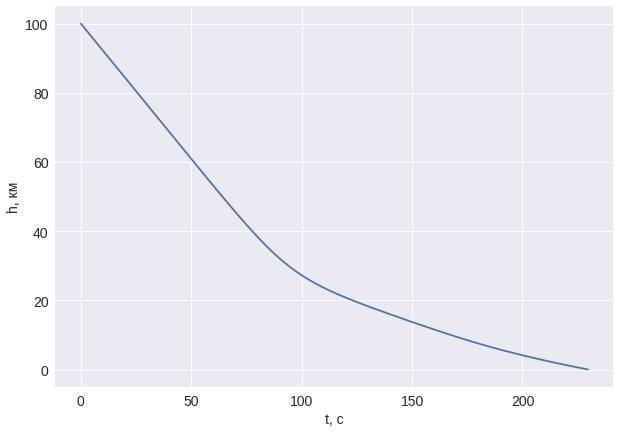

In [0]:
# Зависимость высоты от времени
plt.plot(sol.t,(sol.y[0]-Re)*0.001);
plt.xlabel('t, c');plt.ylabel('h, км');

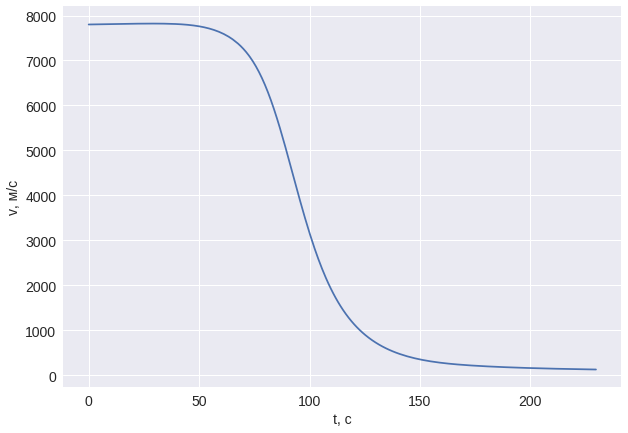

In [0]:
# Зависимость скорости от времени
plt.plot(sol.t,sol.y[1]);
plt.xlabel('t, c');plt.ylabel('v, м/с');

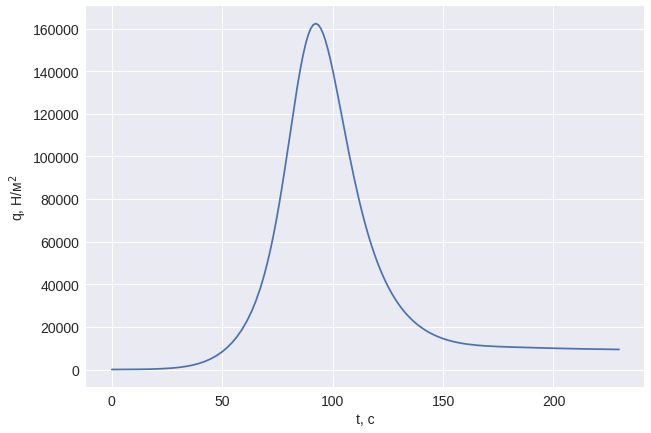

In [0]:
# Зависимость скоростного напора от времени
plt.plot(sol.t,rho((sol.y[0]-Re)*0.001)*sol.y[1]*sol.y[1]/2.0);
plt.xlabel('t, c');plt.ylabel('q, Н/м$^2$');

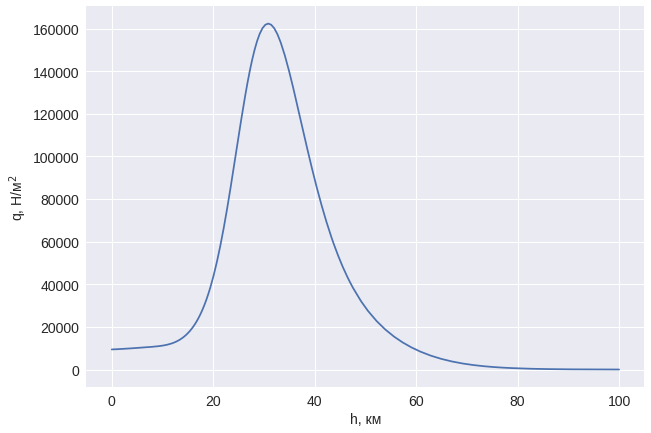

In [0]:
# Зависимость скоростного напора от высоты
plt.plot((sol.y[0]-Re)*0.001,rho((sol.y[0]-Re)*0.001)*sol.y[1]*sol.y[1]/2.0);
plt.xlabel('h, км');plt.ylabel('q, Н/м$^2$');